## Feature Importance

from Notebook Filtering.ipynb after statistical Analyis, we continue this notebook with 5 dataframes :   
  **Influencers_OLS** filtered data from original by threshold 0.2% abundance and frequency minimum of 3, selected genera for significance with the risk label using Ordinary Least Squares (OLS).   
  **OLS_all** selected data from the original underwent selection of significance by OLS.  
  **uniques_OLS** selected data from the original only Genera samples that do no share category were selected, posterior underwent selection of significance by OLS.  
  **uniques_23_OLS** selected data from the original only Genera samples that do no share category were selected, plus the common genera from category 2 and 3, posterior underwent selection of significance by OLS.   
  **Original** dataframe as baseline for comparison  

Starting with 5 different df: OLS_all, Influencers_OLS, uniques_OLS, uniques_23_OLS, original apply the following pipelines
1. Apply Pipelines:
   * PCA visual scree plot and PCA scatterplot:
        These focus on the dimensionality reduction aspect and the structure of the data in the reduced space.  
   * PCA  Feature Influence , explained variance
     This focuses on how each feature contributes to the variance explained by the principal components.
   * Random Forest Regression- Feature importance
   * Random Forest Classification- Feature importance
2. Visually comparing Feature Importances and Influences:
   * Extract feature importances from the Random Forest models. 
     This focuses on the predictive power of each feature in the context of a Random Forest model
   * Extract feature influences from the PCA pipeline.
3. Replace IDs/GIDs with Biological Names:
   * Map the feature IDs to their corresponding biological names.
   * Analyze the biological significance of the selected features. For each dataframe and see if they make sense.
4. Combine and Select Most Influential Features:
   * Combine the results from different pipelines according to importance, influence and frequency into a DataFrame.
   * Select the top influential features

__Logistic Regression with L1 Regularization:__ This can help in feature selection by shrinking the coefficients of less important features to zero.
Random Forest or Gradient Boosting: These tree-based models can provide a feature importance score for each GID.
__Influence:__ Since the 'Influence' feature accounts for both abundance and frequency, it might be worthwhile to also consider this feature in the analysis. We can repeat the above steps using 'Influence' as the dependent variable instead of 'Abundance' to see if it provides any additional insights. Additionally at the end we have a list of most relevant Genera to continue to book 4.

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import braycurtis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from IPython.display import display, HTML

In [46]:
pd.options.display.float_format = '{:.4f}'.format
#Reading the data
OLS_all_o = pd.read_excel('data/OLS_all.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}}) 
Influencers_OLS_o = pd.read_excel('data/Influencers_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques_OLS_o = pd.read_excel('data/uniques_cat.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques_23_OLS_o = pd.read_excel('data/uniques_plus_23.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
original_o = pd.read_excel('data/original.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})

In [47]:
def clean_dataframe(df):
    return (df.drop(columns='Unnamed: 0', axis=1)
        .astype({'Sites': str, 'Category': int})
        .set_index("Sites"))

OLS_all_o = clean_dataframe(OLS_all_o)
Influencers_OLS_o = clean_dataframe(Influencers_OLS_o)
uniques_OLS_o= clean_dataframe(uniques_OLS_o)
uniques_23_OLS_o= clean_dataframe(uniques_23_OLS_o)
original_o['Sites'] = original_o['Sites'].astype(str)

### PCA explained_variance_ratio -Screeplot and PCA plot

In [48]:
def prepare_data(df, category_column, index_column=None):
    df_prepared = df.copy()
    if index_column:
        df_prepared = df_prepared.set_index(index_column)
    category = df_prepared[category_column]
    df_prepared = df_prepared.drop(columns=[category_column], axis=1)
    return df_prepared, category

def standardize_data(df):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    return pd.DataFrame(X_scaled, columns=df.columns)

def perform_pca(X_scaled, n_components=None):
    if n_components is None:
        pca = PCA()
    else:
        pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    return pca, X_pca, explained_variance_ratio, cumulative_variance_ratio

def plot_scree(pca, title):
    explained_var = pca.explained_variance_ratio_
    plt.figure(figsize=(7, 5))
    plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(explained_var) + 1), np.cumsum(explained_var), where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.title(title) # "Explained Variance Ratio by Principal Components"
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plot_pca_2d(X_pca, category, title):
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['Category'] = category.values
    colors = ['green', 'orange', 'red']
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", hue="Category", data=pca_df, palette=colors)
    plt.title(title)# "Data Points in Reduced Dimensional Space (PCA)"
    plt.show()

def pca_pipeline(df, category_column, index_column=None, n_components=None, dataset_name=None):
    df_prepared, category = prepare_data(df, category_column, index_column)
    X_scaled = standardize_data(df_prepared)

    # Perform PCA with all components for scree plot
    pca_all = PCA()
    pca_all.fit(X_scaled)
    explained_variance_ratio = pca_all.explained_variance_ratio_
    
    # Perform PCA with selected components for visualization
    pca, X_pca, explained_variance_ratio, cumulative_variance_ratio = perform_pca(X_scaled, n_components)
    
    if dataset_name:
        plot_scree(pca_all, f"Scree Plot for {dataset_name}")
        plot_pca_2d(X_pca, category, f"PCA 2D Visualization for {dataset_name}")
    
    results = {
        'pca': pca,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance_ratio': cumulative_variance_ratio,
        'X_pca': X_pca
    }
    return results

### PCA Feature Importance and Explained Variance by Original Feature

In [49]:
def apply_pipeline_pca(df, dataset_name, n_components, n_top_features=20):
    print(f"{dataset_name}_pipeline:") 

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()  # 
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target
    X = df.drop(columns=['Category', 'Sites'])
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    # K-Fold cross-validation
    kf = KFold(n_splits=5)
    
    pca_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
                    
    # Fit the pipeline to the training data
    pca_pipeline.fit(X_train)

    # Extract the number of components and explained variance
    n_components = pca_pipeline.named_steps['pca'].n_components_
    
    # Get the loadings from the PCA object
    loadings = pca_pipeline.named_steps['pca'].components_
    
    # Calculate the absolute sum of loadings for each feature
    feature_influence = np.sum(np.abs(loadings), axis=0)
    
    # Create DataFrame with feature influences
    df_pca_influence = pd.DataFrame({
        'Features': X.columns,
        'Influence': feature_influence
    }).sort_values(by='Influence', ascending=False)

    # Limit the DataFrame to the top n_top_features
    df_pca_influence = df_pca_influence.head(n_top_features)

   # Explained variance by original feature
    explained_variance = pd.DataFrame({
        'Component': range(1, n_components + 1),
        'Explained Variance Ratio':  pca_pipeline.named_steps['pca'].explained_variance_ratio_
    }).head(25)
    
    return pca_pipeline, df_pca_influence, explained_variance, n_components

### Diplaying the Results

In [50]:
def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

### Computing PCA and Varianza -Scree Plots for Influencers_OLS
selected data from the original with abundance threshold of 0,2% and frequency of 3, underwent selection of significance by OLS

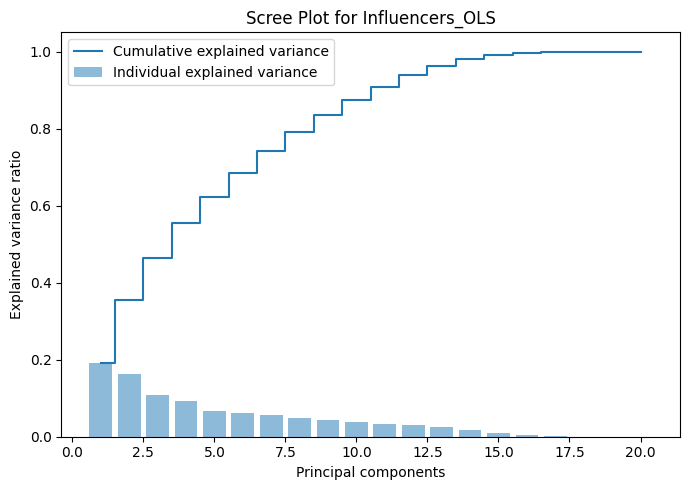

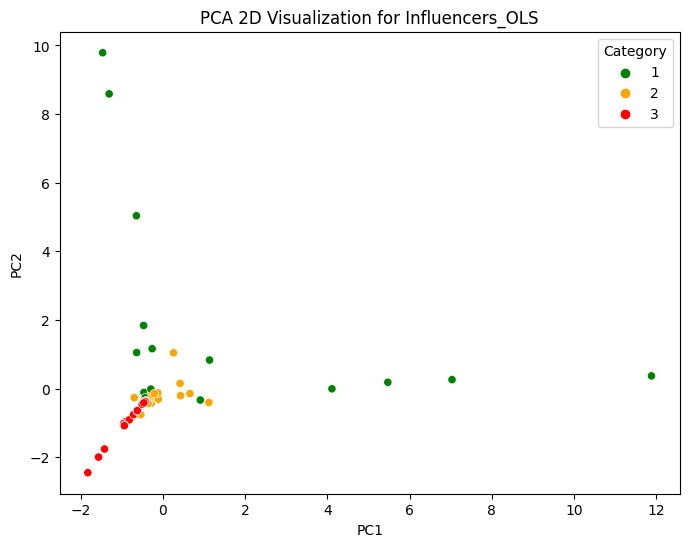

Influencers_OLS_pipeline:


,Features,Influence
15,351,2.3880
5,214,2.2835
0,678,2.2209
8,863,2.1979
10,526,2.1441
11,584,2.0509
13,408,1.9783
3,864,1.6802
19,471,1.6356
14,91,1.4883


In [51]:
# Aply pipeline for visual results
Influencers_OLS_pca = pca_pipeline(Influencers_OLS_o, 'Category', n_components=2, dataset_name='Influencers_OLS')
# Apply the pipeline for numerical results
Influencers_OLS_pca_pipeline, df_pca_influence_influencers, explained_variance_influencers, n_components = apply_pipeline_pca(Influencers_OLS_o, "Influencers_OLS", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence_influencers, explained_variance_influencers)

**Influencers_OLS**:
   - This dataframe, representing the most influential genera both statistically and quantitatively, shows a clearer separation among the categories, especially between category 3 and 1. 
   - Category 3 There is a clear regression trend in category 3 
   - Category 2 dots align in the middle, indicating they share some characteristics with category 3 but also have distinct features.
   - Category 1 displays a 'v' shape, with category 3 forming the root, category 2 at the intersection, and the two arms of the 'Y' representing the spread of category 1. This pattern might indicate that category 1 encompasses a broader range of variance or interactions compared to the other categories.  

__Scree Plots:__ The Influencers_OLS dataset appears to decrease its explained variance more steeply compared to the OLS_all dataset.

### Computing PCA and Varianza -Scree Plots for OLS_all
selected data from the original underwent selection of significance by OLS.

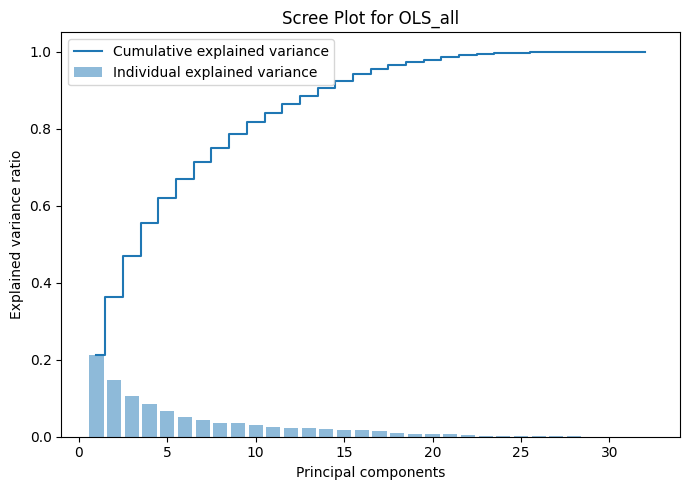

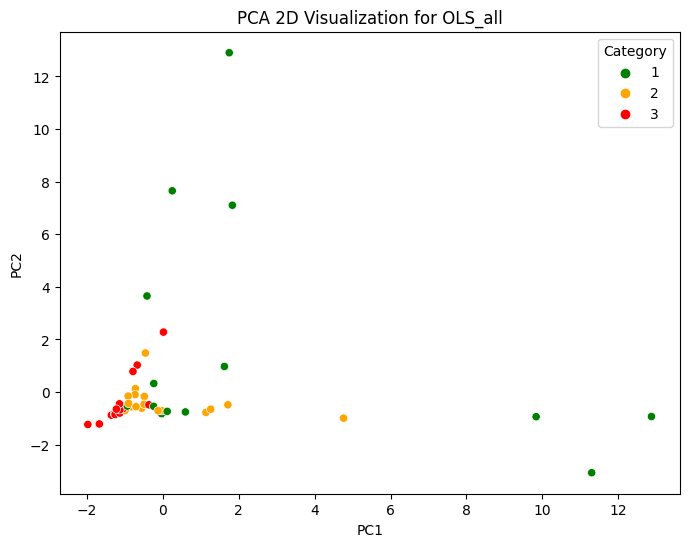

OLS_all_pipeline:


,Features,Influence
12,92,2.8745
17,584,2.7563
14,625,2.7317
15,229,2.6060
23,201,2.5696
0,678,2.4565
11,470,2.4488
22,428,2.2496
3,342,2.1915
20,657,2.0984


In [52]:
# Aply pipeline for visual results
OLS_all_pca = pca_pipeline(OLS_all_o, 'Category', n_components=2, dataset_name='OLS_all')
# Apply the pipeline for numerical results
OLS_all_pca_pipeline, df_pca_influence_OLS_all, explained_variance_OLS_all, n_components = apply_pipeline_pca(OLS_all_o, "OLS_all", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence_OLS_all, explained_variance_OLS_all)

**OLS_all**:
   - The scenario for the whole data is more intricate. The categories are not as distinctly separated, indicating a more complex interplay of features.
   - While category 1 also forms a 'Y' shape, the distinction is less clear due to the overlap with categories 2 and 3. This overlap suggests shared characteristics or interactions among the categories.

In both scree plots, OLS_all and Influencers_OLS a clear "elbow point" is observed around the 5th principal component. This suggests that retaining the first 5 components captures a significant portion of the variance in the data. However, Influencers_OLS seems to achieve a higher explanatory power with fewer features compared to OLS_all, moreover the differentiation on the labels makes this dataset more relevant. According to the principle of parsimony or Occam's Razor, which states that among competing hypotheses, the one with the fewest assumptions should be selected, in this case Influencers_OLS. Until the biological significance is not accounted for, the datasets are to be retained for comparison.

### Computing PCA and Varianza -Scree Plots for uniques_OLS
selected data from the original only Genera samples that do no share category were selected, posterior underwent selection of significance by OLS.

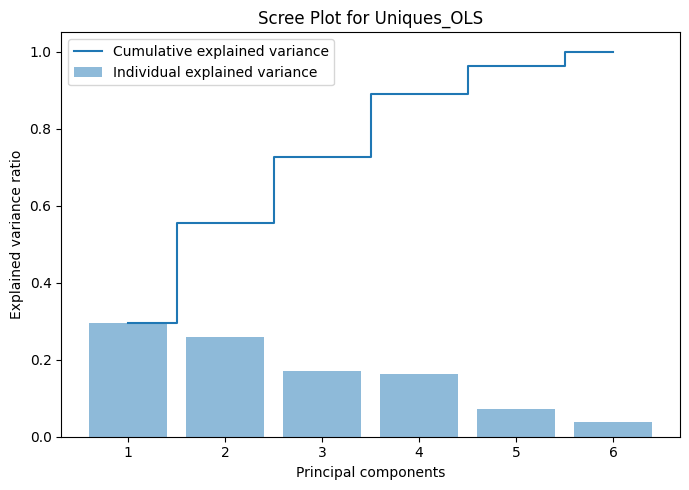

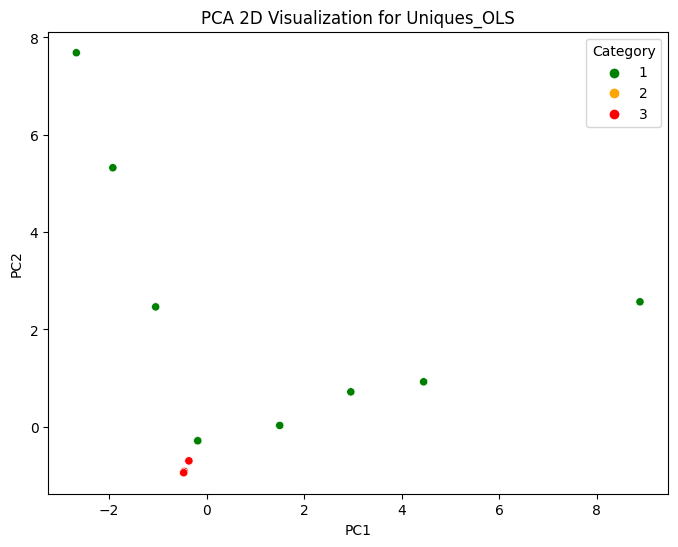

Uniques_OLS_pipeline:


,Features,Influence
0,410,2.0235
1,342,1.9286
4,799,1.7271
2,201,1.4755
5,494,1.0109
3,541,0.9773
,Component,Explained Variance Ratio
0,1,0.3172
1,2,0.2873
2,3,0.1732


In [53]:
# Aply pipeline for visual results
uniques_OLS_pca = pca_pipeline(uniques_OLS_o, 'Category', n_components=2, dataset_name='Uniques_OLS')
# Apply the pipeline for numerical results
uniques_OLS_pca_pipeline, df_pca_influence_uniques_OLS, explained_variance_uniques_OLS, n_components = apply_pipeline_pca(uniques_OLS_o, "Uniques_OLS", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques_OLS, explained_variance_uniques_OLS)

**uniques_OLS**:
   - Uniques_OLS is compound of only 6 features and interestingly it shows the best differenciation on the pca of the components. Also the varianza increases from 0.2 on the previous dfs to 0.3 explained variance. Showing that this features can explain better the dataset in reference to the corrosion rick label. 
   - The v shape of the category 1 is very clear and so is the lineal presence of category 3.  

### Computing PCA and Varianza -Scree Plots for uniques_23_OLS
selected data from the original only Genera samples that do no share category were selected, plus the common genera from category 2 and 3, posterior underwent selection of significance by OLS.

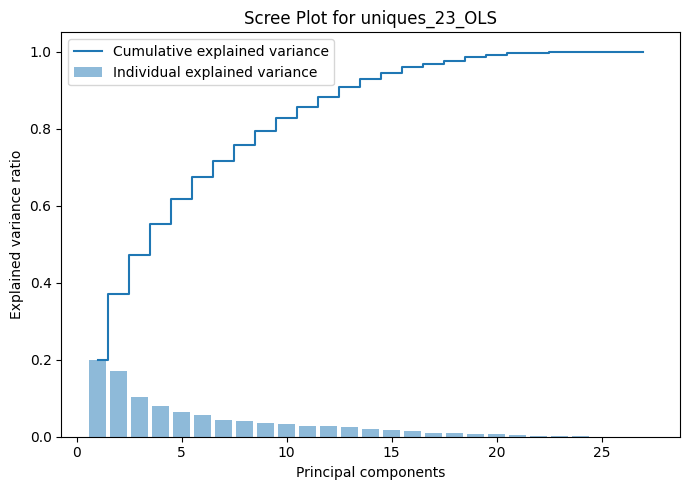

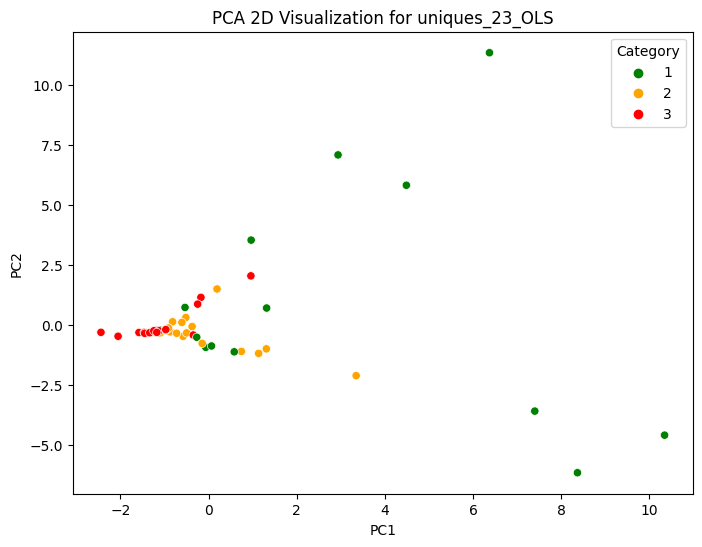

uniques_23_OLS_pipeline:


,Features,Influence
11,625,2.5578
13,584,2.5408
18,201,2.4363
12,229,2.4231
15,799,2.3797
0,678,2.2436
23,88,2.1551
8,214,2.0959
2,410,2.0397
5,140,1.9158


In [54]:
# Aply pipeline for visual results
uniques_23_OLS_pca = pca_pipeline(uniques_23_OLS_o, 'Category', n_components=2, dataset_name='uniques_23_OLS')
# Apply the pipeline for numerical results
uniques_23_OLS_pca_pipeline, df_pca_influence_uniques23, explained_variance_uniques23, n_components = apply_pipeline_pca(uniques_23_OLS_o, "uniques_23_OLS", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques23, explained_variance_uniques23)

**unique_23__OLS**:
   - Uniques_23 is compose of more as 300 features and interestingly shows the worst differenciation blobs on the pca components. Also the varianza decreases from 0.3 on the previous df to 0.2 explained variance. Showing that this features have to be decreased in order to increase significance in reference to the corrosion rick label. 
   - Category 1 has very clear separation similar to the previous dataframes, however 2 and 3 are overlaped yet feature 3 continues to present a lineal regresion between the two PC.

### Computing PCA and Varianza -Scree Plots for original
Original dataframe as baseline for comparison

In [ ]:
# Aply pipeline for visual results
original_pca = pca_pipeline(original_o, 'Category', n_components=2, dataset_name='original_OLS')
# Apply the pipeline for numerical results
original_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(original_o, "original_OLS", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence, explained_variance)

**original**:
   - original shows no aglomeration nor useful information which is expected the noise due to the large amount of data and features/sample ratio.

### Pipeline for Regression

In [56]:
def apply_pipeline_regressor(df, dataset_name):
    print(f"{dataset_name}_pipeline:") 

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()  # 
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target
    X = df.drop(columns=['Category', 'Sites'])
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    # K-Fold cross-validation
    kf = KFold(n_splits=5)
    rf_mae_scores = []

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    
        # Fit and predict
        rf_pipeline.fit(X_train, y_train)
        # Predict the labels of the test set
        y_pred = rf_pipeline.predict(X_test)
    
        # Calculate and store MAE
        mae = mean_absolute_error(y_test, y_pred).round(4)
        rf_mae_scores.append(mae)

    print(f"Cross-Validation MAE Scores for RF: {rf_mae_scores}")
    print(f"Average MAE for RF: {np.mean(rf_mae_scores).round(4)}")
      
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred).round(4)
    print(f'Mean Squared Error: {mse}')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(4)
    print(f'Root Mean Squared Error: {rmse}')
    mae = mean_absolute_error(y_test, y_pred).round(4)
    print(f'Mean Absolute Error: {mae}')

    # Extract feature importances from RandomForestRegressor
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_
    
    # Create a DataFrame to view the results
    df_importances_rf = pd.DataFrame({
            'Features': X.columns,
            'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False) # Sort the features by importance
    
    print(f'Feature Importance by RF: {df_importances_rf.head(25)}')
          
    return rf_pipeline, df_importances_rf

* **MSE (Mean Squared Error):** Measures the average of the squares of the errors.
* __RMSE (Root Mean Squared Error):__ Square root of MSE. It's in the same units as the output variable and gives a higher penalty for larger errors.
* __MAE (Mean Absolute Error):__ Measures the average of the absolute errors.

In [57]:
Influencers_pipeline_rg, Importances_rf_Influencers = apply_pipeline_regressor(Influencers_OLS_o, "Influencers_OLS")

Influencers_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.3274, 0.2214, 0.1426, 0.1784, 0.34]
Average MAE for RF: 0.242
Mean Squared Error: 0.2618
Root Mean Squared Error: 0.5116
Mean Absolute Error: 0.34
Feature Importance by RF:    Features  Importance
10      526      0.4318
6       549      0.1748
7       625      0.0948
3       864      0.0908
16      375      0.0595
5       214      0.0459
9       229      0.0309
1       565      0.0289
13      408      0.0092
11      584      0.0070
19      471      0.0056
14       91      0.0055
15      351      0.0050
2        23      0.0042
17      334      0.0033
8       863      0.0019
12      725      0.0010
4       712      0.0000
18      871      0.0000
0       678      0.0000


**Influencers_OLS Pipeline:**
Cross-Validation MAE Scores for RF: Consistently lower and less variable (ranging from 0.1426 to 0.34) with a significantly lower average MAE (0.242).
Error Metrics:
MSE: 0.2618; RMSE: 0.5116; MAE: 0.34  

These metrics demonstrate improved prediction accuracy and model reliability compared to OLS_all.
Feature importance is more concentrated, with feature 526 having an overwhelming impact (importance: 0.4318).
Other features like 549 and 625 show noticeable contributions but to a lesser extent.

In [58]:
# Apply the pipeline the working df
OLS_all_pipe_rg, importances_rf_OLS = apply_pipeline_regressor(OLS_all_o, "OLS_all_o")

OLS_all_o_pipeline:
Cross-Validation MAE Scores for RF: [0.6886, 0.6021, 0.3935, 0.6148, 0.5634]
Average MAE for RF: 0.5725
Mean Squared Error: 0.3921
Root Mean Squared Error: 0.6262
Mean Absolute Error: 0.5634
Feature Importance by RF:    Features  Importance
13      549      0.1883
6        23      0.1233
14      625      0.0887
9       214      0.0845
15      229      0.0751
7       140      0.0611
11      470      0.0488
17      584      0.0425
21       91      0.0410
1       565      0.0295
26      334      0.0287
0       678      0.0240
29      337      0.0220
22      428      0.0193
5       605      0.0176
19      799      0.0143
28       88      0.0134
4       771      0.0124
18      725      0.0108
16       79      0.0089
30      871      0.0085
8       712      0.0081
31      480      0.0064
24      426      0.0060
3       342      0.0043


Cross-Validation MAE Scores for RF: Higher variability across folds (ranging from 0.3935 to 0.6886) and a higher average MAE (0.5725) suggest that the model's predictive performance is less consistent.
Error Metrics:
Mean Squared Error (MSE): 0.3921; Root Mean Squared Error (RMSE): 0.6262;Mean Absolute Error (MAE): 0.5634
These metrics indicate lower prediction accuracy compared to the Influencers_OLS pipeline.
**Importance** is more evenly distributed, with no single feature dominating.
Top features (e.g., feature 549, 23, and 625) exhibit moderate importance values (0.1883, 0.1233, 0.0887).

In [59]:
uniques_pipeline, importances_rf_uniques = apply_pipeline_regressor(uniques_OLS_o, "Uniques_OLS")

Uniques_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.6922, 0.6703, 0.3881, 0.3783, 0.7313]
Average MAE for RF: 0.572
Mean Squared Error: 0.7412
Root Mean Squared Error: 0.8609
Mean Absolute Error: 0.7313
Feature Importance by RF:   Features  Importance
3      541      0.2426
1      342      0.2327
0      410      0.2050
2      201      0.1732
4      799      0.1180
5      494      0.0285


**uniques_OLS_pipeline:**
Cross-Validation MAE Scores for RF: Higher variability (range 0.3783–0.7313) and a comparable average MAE (0.572).  
Error Metrics:  
MSE: 0.7412 ; RMSE: 0.8609 ; MAE: 0.7313 (relatively high).  
These metrics reflect suboptimal predictive performance compared to other datasets.  
Feature Importance:   
Importance is relatively concentrated among the top three features (541: 0.2426, 342: 0.2327, 410: 0.2050), suggesting a model reliant on a few key variables.   

In [60]:
unique_23_OLS_pipeline_rg, importances_rf_uniques23= apply_pipeline_regressor(uniques_23_OLS_o, "unique_23_OLS")

unique_23_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.72, 0.6022, 0.3867, 0.6042, 0.5623]
Average MAE for RF: 0.5751
Mean Squared Error: 0.3868
Root Mean Squared Error: 0.622
Mean Absolute Error: 0.5623
Feature Importance by RF:    Features  Importance
10      549      0.1899
6        23      0.1025
11      625      0.0889
8       214      0.0879
12      229      0.0750
5       140      0.0552
9       470      0.0545
16       91      0.0410
13      584      0.0407
1       565      0.0294
21      334      0.0288
23       88      0.0267
17      428      0.0261
0       678      0.0259
4       605      0.0224
24      337      0.0214
15      799      0.0183
14      725      0.0177
7       712      0.0137
25      871      0.0082
2       410      0.0081
3       342      0.0055
19      426      0.0044
26      480      0.0037
20      541      0.0024


unique_23_OLS_pipeline:
Cross-Validation MAE Scores for RF: Less variability (range 0.3867–0.72) and slightly higher average MAE (0.5751).
Error Metrics:
MSE: 0.3868 ; RMSE: 0.622 ; MAE: 0.5623 (lower than uniques_OLS)   

These metrics indicate better performance than uniques_OLS, possibly due to the model leveraging a larger pool of features.

**Feature importance** is more evenly distributed across top contributors (e.g., 549: 0.1899, 23: 0.1025, 625: 0.0889).
High-dimensionality could contribute to complexity but might also capture subtle interactions.  

**unique_23_OLS_pipeline** achieves slightly better predictive accuracy despite higher dimensionality, possibly due to capturing more complex interactions, performs better numerically. Suggesting that the dataset's complexity adds value despite reduced interpretability.
**uniques_OLS_pipeline**, though concise, has poorer error metrics, indicating potential underfitting or missing interactions and struggles with predictive accuracy.

In [61]:
original_pipeline, df_importances_rf= apply_pipeline_regressor(original_o, "unique_23_OLS")

unique_23_OLS_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An er

Cross-Validation MAE Scores for RF: [0.7793, 0.5543, 0.47, 0.4157, 0.7286]
Average MAE for RF: 0.5896
Mean Squared Error: 0.7096
Root Mean Squared Error: 0.8424
Mean Absolute Error: 0.7286
Feature Importance by RF:        Features  Importance
316         315      0.0815
550         549      0.0640
274         273      0.0393
492         491      0.0357
147         146      0.0316
144         143      0.0273
615         614      0.0250
678         677      0.0250
527         526      0.0246
324         323      0.0238
573         572      0.0232
409         408      0.0219
603         602      0.0217
270         269      0.0188
626         625      0.0169
24           23      0.0158
376         375      0.0156
1    Unnamed: 0      0.0139
415         414      0.0128
215         214      0.0125
246         245      0.0122
590         589      0.0121
114         113      0.0121
0         index      0.0111
504         503      0.0110


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### Pipeline for Clasification

In [62]:
def apply_classification_pipeline_classif(df, dataset_name):
    print(f"{dataset_name}_pipeline:") 

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()  # 
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target
    X = df.drop(columns=['Category', 'Sites'])
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    # K-Fold cross-validation
    kf = KFold(n_splits=5)
    rf_scores = []

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    
        # Fit and predict
        rf_pipeline.fit(X_train, y_train)
        # Predict the labels of the test set
        y_pred = rf_pipeline.predict(X_test)
    
        # Calculate and store accuracy
        accuracy = accuracy_score(y_test, y_pred).round(4)
        rf_scores.append(accuracy)

    print(f"Cross-Validation Accuracy Scores for RF: {rf_scores}")
    print(f"Average Accuracy for RF: {np.mean(rf_scores).round(4)}")
    
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Extract feature importances from RandomForestClassifier
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_
    
    # Create a DataFrame to view the results
    df_importances_rf = pd.DataFrame({
            'Features': X.columns,
            'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False) # Sort the features by importance
    
    print(f'Feature Importance by RF: {df_importances_rf}')
          
    return rf_pipeline, df_importances_rf

In [63]:
# Apply the pipeline the working df
Influencers_pipe_class, importances_class_I = apply_classification_pipeline_classif(Influencers_OLS_o, "Influencers_OLS")

Influencers_OLS_pipeline:
Cross-Validation Accuracy Scores for RF: [0.7857, 0.7857, 0.9286, 0.9286, 0.7143]
Average Accuracy for RF: 0.8286
Confusion Matrix:
[[2 1 0]
 [0 7 0]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.64      1.00      0.78         7
           3       1.00      0.25      0.40         4

    accuracy                           0.71        14
   macro avg       0.88      0.64      0.66        14
weighted avg       0.82      0.71      0.67        14

Feature Importance by RF:    Features  Importance
10      526      0.2326
6       549      0.1008
3       864      0.0839
16      375      0.0785
5       214      0.0720
7       625      0.0653
9       229      0.0643
19      471      0.0459
15      351      0.0416
1       565      0.0406
8       863      0.0399
11      584      0.0371
14       91      0.0231
13      408      0.0211
12      725      0.0159

**Influencers_OLS_pipeline:**
Performance Metrics:   
Cross-Validation Accuracy: 0.8286 (high and consistent across folds).  
Confusion Matrix:   
Class 1: Perfect precision but lower recall (misclassifications lead to only 67% recall).  
Class 2: High recall (100%) but lower precision (64%).   
Class 3: High precision (100%) but very low recall (25%), indicating many false negatives.  
Classification Report:  
Macro average recall (0.64) suggests unbalanced performance across classes.  
Weighted average metrics reflect an overall acceptable but not ideal model for classifying all categories equally well.  
Feature Importance:  
Feature 526 dominates (23.26%), followed by moderately impactful features like 549 and 864.  

In [64]:
# Apply the pipeline the working df
OLS_all_pipe_class, importances_class_O = apply_classification_pipeline_classif(OLS_all_o, "OLS_all_o")

OLS_all_o_pipeline:
Cross-Validation Accuracy Scores for RF: [0.2857, 0.5, 0.6429, 0.5, 0.4286]
Average Accuracy for RF: 0.4714
Confusion Matrix:
[[1 4 1]
 [0 5 1]
 [0 2 0]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.17      0.29         6
           2       0.45      0.83      0.59         6
           3       0.00      0.00      0.00         2

    accuracy                           0.43        14
   macro avg       0.48      0.33      0.29        14
weighted avg       0.62      0.43      0.37        14

Feature Importance by RF:    Features  Importance
15      229      0.1138
9       214      0.1074
6        23      0.0912
13      549      0.0715
21       91      0.0614
1       565      0.0534
17      584      0.0527
14      625      0.0460
0       678      0.0447
7       140      0.0434
5       605      0.0400
18      725      0.0355
11      470      0.0270
28       88      0.0246
29      337      0.0238
22      428

**OLS_all_pipeline:**
Performance Metrics:   
Cross-Validation Accuracy: 0.4714 (significantly lower, inconsistent across folds).  
Confusion Matrix:   
Class 1: Perfect precision but extremely low recall (17%), with many false negatives.   
Class 2: Moderate precision (45%) and high recall (83%), indicating a focus on this class.  
Class 3: Zero precision and recall, indicating an inability to classify this category.  
Classification Report:   
Macro and weighted averages are much lower than Influencers_OLS, indicating an overall weaker model.  
Feature Importance:   
Importance is more distributed but lower overall contributions compared to Influencers_OLS.   

In [65]:
# Apply the pipeline the working df
uniques_pipe_class, importances_class_U = apply_classification_pipeline_classif(uniques_OLS_o, "unique_OLS")

unique_OLS_pipeline:
Cross-Validation Accuracy Scores for RF: [0.3571, 0.5, 0.7143, 0.6429, 0.4286]
Average Accuracy for RF: 0.5286
Confusion Matrix:
[[0 6 0]
 [0 6 0]
 [0 2 0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.43      1.00      0.60         6
           3       0.00      0.00      0.00         2

    accuracy                           0.43        14
   macro avg       0.14      0.33      0.20        14
weighted avg       0.18      0.43      0.26        14

Feature Importance by RF:   Features  Importance
2      201      0.2338
3      541      0.2117
1      342      0.2011
0      410      0.1924
4      799      0.1181
5      494      0.0429


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
# Apply the pipeline the working df
uniques23_pipe_class, importances_class_U23 = apply_classification_pipeline_classif(uniques_23_OLS_o, "unique_23_OLS")

unique_23_OLS_pipeline:


Cross-Validation Accuracy Scores for RF: [0.3571, 0.4286, 0.7143, 0.5, 0.4286]
Average Accuracy for RF: 0.4857
Confusion Matrix:
[[0 6 0]
 [0 6 0]
 [0 2 0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.43      1.00      0.60         6
           3       0.00      0.00      0.00         2

    accuracy                           0.43        14
   macro avg       0.14      0.33      0.20        14
weighted avg       0.18      0.43      0.26        14

Feature Importance by RF:    Features  Importance
12      229      0.1091
6        23      0.1082
8       214      0.1066
10      549      0.0697
16       91      0.0664
5       140      0.0582
0       678      0.0490
1       565      0.0483
13      584      0.0441
11      625      0.0408
4       605      0.0340
14      725      0.0340
17      428      0.0304
24      337      0.0301
23       88      0.0282
9       470      0.0279
15  

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
# Apply the pipeline the working df
original_pipe_class, df_importances_rf = apply_classification_pipeline_classif(original_o, "original_o")

original_o_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An er

Cross-Validation Accuracy Scores for RF: [0.5, 0.5714, 0.3571, 0.6429, 0.4286]
Average Accuracy for RF: 0.5
Confusion Matrix:
[[1 4 1]
 [1 5 0]
 [0 2 0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.17      0.25         6
           2       0.45      0.83      0.59         6
           3       0.00      0.00      0.00         2

    accuracy                           0.43        14
   macro avg       0.32      0.33      0.28        14
weighted avg       0.41      0.43      0.36        14

Feature Importance by RF:     Features  Importance
492      491      0.0162
573      572      0.0152
527      526      0.0152
0      index      0.0143
865      864      0.0122
..       ...         ...
459      458      0.0000
455      454      0.0000
454      453      0.0000
453      452      0.0000
505      504      0.0000

[884 rows x 2 columns]


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An er

Revisiting unique_23_OLS and working only with the first 25 features

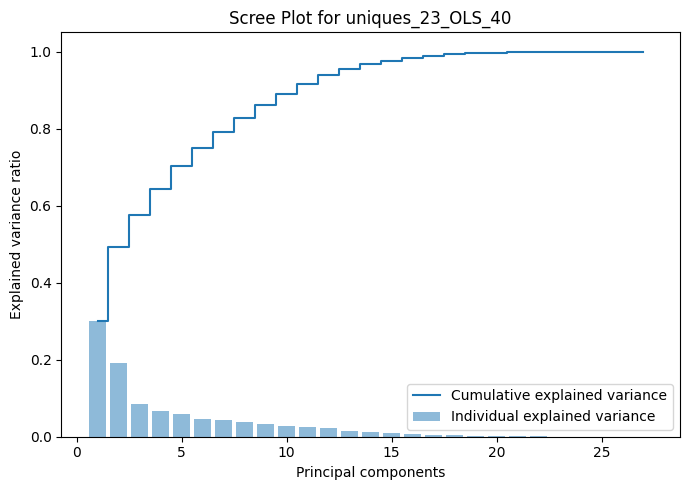

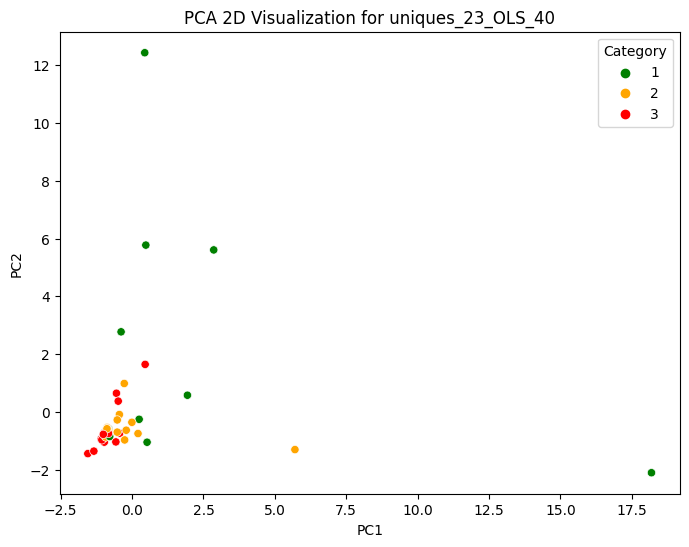

uniques_23_OLS_40_pipeline:


,Features,Influence
12,229,2.6278
13,584,2.4608
18,201,2.4091
0,678,2.2634
15,799,2.1521
3,342,2.0441
9,470,2.0099
5,140,2.0066
17,428,1.9124
23,88,1.8857


unique_23_OLS_40_pipeline:
Cross-Validation MAE Scores for RF: [0.708, 0.5599, 0.6534, 0.4252, 0.4717]
Average MAE for RF: 0.5636
Mean Squared Error: 0.3112
Root Mean Squared Error: 0.5578
Mean Absolute Error: 0.4717
Feature Importance by RF:    Features  Importance
10      549      0.1777
11      625      0.1469
6        23      0.1236
12      229      0.1069
9       470      0.0628
5       140      0.0507
13      584      0.0380
16       91      0.0376
23       88      0.0286
17      428      0.0272
4       605      0.0270
8       214      0.0258
1       565      0.0228
14      725      0.0225
24      337      0.0216
0       678      0.0197
21      334      0.0132
15      799      0.0128
25      871      0.0090
26      480      0.0067
19      426      0.0059
7       712      0.0045
3       342      0.0040
2       410      0.0026
18      201      0.0018
unique_23_OLS_pipeline:
Cross-Validation Accuracy Scores for RF: [0.3, 0.6, 0.4, 0.6, 0.6]
Average Accuracy for RF: 0.5
Confusion Mat

In [81]:
# Aply pipeline for visual results
uniques_23_OLS_pca_40 = pca_pipeline(uniques_23_OLS_o.head(50), 'Category', n_components=2, dataset_name='uniques_23_OLS_40')
# Apply the pipeline for numerical results
uniques_23_pca_pipeline_40, df_pca_influence_uniques23_40, explained_variance_uniques23_40, n_components = apply_pipeline_pca(uniques_23_OLS_o.head(50), "uniques_23_OLS_40", n_components=2 ,n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques23_40, explained_variance_uniques23_40)
unique_23_OLS_pipeline_rg_40, importances_rf_uniques23_40 = apply_pipeline_regressor(uniques_23_OLS_o.head(50), "unique_23_OLS_40")
# Apply the pipeline the working df
uniques23_pipe_class_40, importances_class_U23_40 = apply_classification_pipeline_classif(uniques_23_OLS_o.head(50), "unique_23_OLS")

Revisiting unique_23_OLS, didnt keep the level of explaned varianz that uniques_23 had, nor the data was seen on a more disernible pattern, meaning that the features that were improving the model are no amongst the 25 first. Later I did it with 30, 40, 50 and 60. A summary of the results is as follows: 
Performance Trend Analysis:

Mean Absolute Error (MAE) Progression:
25 features: 0.8289
30 features: 0.7509
40 features: 0.7259
50 features: 0.5636 (Significant improvement)
60 features: 0.609 (Slight regression)

Variance and Model Complexity:
As features increase from 25 to 50, the model captures more variance
The 50-feature model represents the optimal balance between complexity and performance
Beyond 50 features, the gains diminish, and error starts to increase slightly
Key Observations:
50 features provide the best trade-off between:
Lowest Mean Absolute Error
Most stable cross-validation scores
Most balanced feature importance distribution
Additional features beyond 50 start introducing noise rather than meaningful information

## Comparison of the Feature Importance and Feature Influence
### Influencers_OLS, OLS_all and uniques_23 

In [341]:
# Create a function to display side-by-side
def display_side_by_side(*args, titles=()):
    """Display multiple DataFrames side-by-side."""
    html_str = '<div style="display:flex;">'
    for df, title in zip(args, titles):
        html_str += f'<div style="margin-right:20px;"><h3>{title}</h3>' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# Display the data side-by-side
display_side_by_side(df_pca_influence_influencers, Importances_rf_Influencers, df_pca_influence_OLS_all, importances_rf_OLS, df_pca_influence_uniques23, importances_rf_uniques23,  
                     titles=["PCA Influence influencers", "RF Feature Importance influencers", "PCA Influence OLS_all", "RF Feature Importance OLS_all",  "PCA Influence uniques_23", "RF Feature Importance uniques_23"])

,Features,Influence
15,351,2.3880
5,214,2.2835
0,678,2.2209
8,863,2.1979
10,526,2.1441
11,584,2.0509
13,408,1.9783
3,864,1.6802
19,471,1.6356
14,91,1.4883


### Manually prunning the features according to importance and influence

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7] , dtype={**{i: str for i in range(0,2)},
                                                                        **{i:float for i in range(2, 884)}},  skiprows=[8]) # Somehow it was showing an empty row, so skiprow deletes it

# Making sure the sites and categories get read as they should
Jointax["Sites"]= Jointax["Sites"].astype(str)
Jointax["Category"]= Jointax["Category"].values.astype(int)
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
Jointax = Jointax.reset_index(drop=True)
#Setting the sites as index
Jointax = Jointax.set_index("Sites").reset_index()
# Deleting headers names of unnamed levels
Jointax.columns = Jointax.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
#Drop level of Kindom since it is boring
Jointax =Jointax.drop(Jointax.columns[1], axis=1)
#Correcting the Tuple-like Index
Jointax['Sites'] = Jointax['Sites'].map(lambda x: x[0] if isinstance(x, tuple) else x)
Jointax = Jointax.set_index("Sites")

I put all dataframes whole, Influencers, Uniques, Uniques_23 
Selected_Gids = {154, 201, 214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625}

In [335]:
# The df were compared on excel, the most important features and influencial with pca and rf were selected on each df and pruned for replicates, then all df were mixed and chosen the following genera
selected_dfs_gen = 154,201, 214, 229, 334,351, 408, 354, 497,512,565, 581, 583, 584, 606, 621, 625
#selected_dfs_gen = 625, 214,408,229,351,354,565,606,334,584,583,621,581,497,512 # new selected-->
selected_dfs_gen = set(map(str, selected_dfs_gen))

In [336]:
# Initialize an empty list to store the columns to keep
columns_to_keep_dfs = []

# Skip the first two columns ('Header_7', 'GID') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in selected_dfs_gen:
        columns_to_keep_dfs.append(col)

# Filter 'Jointax' to only include the columns in 'columns_to_keep'
selected_dfs = Jointax.loc[:, columns_to_keep_dfs]

In [337]:
# Add back the 'Sites' and 'Category' columns
selected_dfs['Sites'] = Jointax['Sites']
selected_dfs['Category'] = Jointax['Category']
#organising the columns
cols = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in selected_dfs.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]

selected_dfs  = selected_dfs .loc[:, cols]
# Name the levels of the MultiIndex
selected_dfs.columns.names = ['Level1', 'Level2', 'Level3', 'Level4', 'Level5', 'Level6', 'Level7']
# Create a DataFrame of NaNs with the same shape as the first row of the DataFrame to match pipeline starter df
nan_df = pd.DataFrame([np.nan]*selected_dfs.shape[1]).T
nan_df.columns = selected_dfs.columns

# Concatenate the NaN row and the original DataFrame
selected_dfs = pd.concat([nan_df, selected_dfs]).reset_index(drop=False)
selected_dfs.head()


KeyError: 'Sites'

In [ ]:
selected_pipeline, df_importances_rf= apply_pipeline(selected_dfs, "Selected_dfs_rf")

Selected_dfs_rf_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

Selected_1 = 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625  
Mean Absolute Error: 0.5314   
Selected_2 = 154, 214, 229, 334, 336, 351, 408, 354, 471, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 + 471  
Mean Absolute Error: 0.5371  
Selected_3 = 214, 229, 334, 336, 351, 408, 354, 471, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 + 471-154
Mean Absolute Error: 0.5386  
Selected_4 = 23, 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 + 23
Mean Absolute Error: 0.5493  
Selected_5 = 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 +85
Mean Absolute Error: 0.5364  
Selected_5 = 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625  -606
Mean Absolute Error: 0.5514  
+91
Mean Absolute Error: 0.5814  
+2
Mean Absolute Error: 0.5371  
+201
Mean Absolute Error: 0.5264  
+238
Mean Absolute Error: 0.5421  
-336
Mean Absolute Error: 0.5343
+340
Mean Absolute Error: 0.5193
+342
Mean Absolute Error: 0.5143
+201+340+342
Mean Absolute Error: 0.5329
selected_dfs_gen = 154, 214, 229, 334,351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625,342,340,201,428
Mean Absolute Error: 0.5679
+470
Mean Absolute Error: 0.5393
-541
Mean Absolute Error: 0.5179
-541-512
Mean Absolute Error: 0.5364
-512
Mean Absolute Error: 0.5393
+512-541
Mean Absolute Error: 0.5179
-565
Mean Absolute Error: 0.5514
-606
Mean Absolute Error: 0.5407
+,657+705+863+864+871

no no

In [ ]:
selected_pipeline_pca, df_pca_influence= apply_pipeline_pca(selected_dfs, "Selected_dfs_pca")

### Loop to iterate existent selected Genera 
Now I will make a loop to iterate the existing genera and iteratively replace just one to see which model perform better in order to prune more features

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7])#, sort=False)#, dtype={i: float for i in range(2, 882)})
# making sure that the levels all are on str mode
Jointax.columns = Jointax.columns.set_levels([level.astype(str) for level in Jointax.columns.levels])
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
#Correcting the Tuple-like Index
Jointax.index = Jointax.index.map(lambda x: x[0] if isinstance(x, tuple) else x)

In [ ]:
# Original selected GIDs
selected_gen_fin = {154, 201, 214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625}
selected_gen_fin = set(map(str, selected_gen_fin))

mae_results = {}  # Initialize an empty dictionary to store MAE results

for gid_to_remove in selected_gen_fin:
    print(f"Removing GID: {gid_to_remove}")  # Debugging line
    
    # Temporarily remove one GID
    modified_gids = [x for x in selected_gen_fin if x != gid_to_remove]
    
    # Initialize an empty list to store the columns to keep
    columns_to_keep_fin = []
    
    # Filter your original DataFrame to only include the modified GIDs
    for col in Jointax.columns[2:]:
        gid = str(col[-1])
        if gid in modified_gids:
            columns_to_keep_fin.append(col)
            
    selected_dfs_fin = Jointax.loc[:, columns_to_keep_fin]
    
    # Add back the 'Sites' and 'Category' columns
    selected_dfs_fin['Sites'] = Jointax['Sites']
    selected_dfs_fin['Category'] = Jointax['Category']
      
    # Run your pipeline here with the modified_df and get the MAE
    mae = apply_pipeline(selected_dfs_fin, "Modified_Gids")
    
    # Store the MAE result
    mae_results[f'Remove {gid_to_remove}'] = mae

print(mae_results)


| Mean Absolute Error | 0.4438 |
|---------------------|--------|
| **GID**             | **Join_tax**                                         | **Importance** |
| 625                 | Rhodospirillales_Acetobacteraceae_Roseococcus        | 0.1296         |
| 214                 | Clostridiales_Clostridiaceae_Clostridium             | 0.1234         |
| 408                 | Legionellales_Legionellaceae_Legionella              | 0.1132         |
| 229                 | Actinomycetales_Corynebacteriaceae_Corynebacterium   | 0.1052         |
| 351                 | Pasteurellales_Pasteurellaceae_Haemophilus           | 0.1043         |
| 354                 | Oceanospirillales_Halomonadaceae_Halomonas           | 0.1001         |
| 565                 | Bacteroidales_Porphyromonadaceae_Porphyromonas       | 0.0849         |
| 606                 | Xanthomonadale_Paracoccaceae_Rhodobacter             | 0.0564         |
| 334                 | Thermoanaerobacterales_Thermoanaerobacteraceae_XXX   | 0.0517         |
| 584                 | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas | 0.0438         |
| 583                 | Actinomycetales_Micrococcaceae_Pseudarthrobacter     | 0.0306         |
| 621                 | Burkholderiales_Comamonadaceae_Roseateles            | 0.0245         |
| 581                 | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3       | 0.0207         |
| 497                 | Actinomycetales_Cellulomonadaceae_Oerskovia          | 0.0062         |
| 512                 | Clostridiales_Clostridiaceae_Oxobacter               | 0.0055         |


| GID  | Join_tax                                              | Importance |   | GID  | Join_tax                                              | Influence |
|------|-------------------------------------------------------|------------|---|------|-------------------------------------------------------|-----------|
| 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 0.1578     |   | 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 2.5536    |
| 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 0.1568     |   | 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 2.5225    |
| 408  | Legionellales_Legionellaceae_Legionella               | 0.1230     |   | 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 2.3413    |
| 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 0.1044     |   | 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 2.2417    |
| 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 0.0930     |   | 408  | Legionellales_Legionellaceae_Legionella               | 2.2394    |
| 214  | Clostridiales_Clostridiaceae_Clostridium              | 0.0925     |   | 621  | Burkholderiales_Comamonadaceae_Roseateles             | 2.2278    |
| 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 0.0675     |   | 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 2.2168    |
| 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 0.0462     |   | 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 2.1489    |
| 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 0.0443     |   | 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 2.0918    |
| 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 0.0387     |   | 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 1.9865    |
| 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 0.0274     |   | 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 1.7623    |
| 621  | Burkholderiales_Comamonadaceae_Roseateles             | 0.0230     |   | 214  | Clostridiales_Clostridiaceae_Clostridium              | 1.7298    |
| 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 0.0196     |   | 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 1.7265    |
| 512  | Clostridiales_Clostridiaceae_Oxobacter                | 0.0032     |   | 512  | Clostridiales_Clostridiaceae_Oxobacter                | 1.5879    |
| 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 0.0025     |   | 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 1.3106    |


__Consistency in Top Features:__ Both datasets identified Phenylobacterium as the most influential feature. This consistency suggests that this genus plays a pivotal role in the dataset, regardless of the data's granularity.
Variability in Other Features: Beyond the top feature, there's a noticeable divergence in the ranking of genera between the two datasets. This is expected given the different preprocessing steps applied to each dataset.

__Biological Significance:__ The consistent identification of Phenylobacterium in both datasets underscores its potential biological significance. It might be worthwhile to delve deeper into the biological properties or ecological roles of this genus.
__Influence of Data Granularity:__ The influencers genera dataset, being a filtered subset, might capture more specific interactions or characteristics that are overshadowed in the whole dataset. On the other hand, the whole dataset provides a broader perspective, encompassing a wider range of genera interactions.
__Consideration of Other Important Features:__ While the influencers genera dataset offers a more focused view, it might be prudent to consider some of the top features from the whole data. Some of these features, though not present in the filtered dataset, might still play a significant role in the broader microbial community.

__Data Preprocessing:__ The difference in feature importance rankings between the two datasets underscores the impact of data preprocessing. While filtering out low-abundance genera can reduce noise, it might also inadvertently remove genera that play crucial roles in specific contexts.
__Incorporating Biological Knowledge:__ Feature importance derived from machine learning models should be interpreted in conjunction with biological knowledge. For instance, if a genus known to play a vital role in a particular microbial interaction is ranked low, it might be worth revisiting the data or the model.
__Complementary Analysis:__ Consider performing other analyses, like network analysis or pathway enrichment, to gain more insights into the interactions between these top-ranking genera. This can provide a more holistic view of the microbial community's dynamics.
In conclusion, while both datasets offer valuable insights, a balanced approach that considers both the focused view of the influencers and the broader perspective of the whole data might yield the most comprehensive understanding of the microbial community.

I could try to make a combination of the two datasets so to capture all the possible influence from these features, however the problem I see with the combination fo the whole and influencers dataframes is the overlaping of 1 and 3 categories. In the influencers at least there is no this problem, as we can see in the pc1 vs pca2 visualisation. On the other hand there maybe data that I discarded because of abundance and can actually be really good marker, even if trace occurence. 

I am ploting a combination of the two df to visually compare the distribution of each feature across both datasets. Features that have significantly different distributions between the two datasets might be causing the observed differences in PCA or RandomForestRegression results.

From our analysis, it's evident that the importance of specific bacteria in describing the data isn't necessarily associated with a particular category. At this stage, our primary objective is to identify features that align with the labels, rather than pinpointing features that exclusively mark category 3. Ideally, we should identify distinct markers for each category. 

My hesitation to integrate the two dataframes, is valid. One dataframe, final_influencers was differenciated better amongst categories on the pca plot. On the contrary final_whole has some overlapping.  Some of the genera that we see in the plots are really bad markers, for instance veillonella spreads on category 1 for a lot of sites, and have high abundance on two sites, there is a site on categories 2 and 3, so it is present ubiquotus anyway and it actually could be problematic, but actually also lives on no compromised systems, so no a definitive good marker. Similar hapends with other several genera. Few of them have high numbers on category 3, there is no really one genus that represents 1 because they also belong to the others categories. Category 2 on the other hand only have 3 clear representatives one of them mixed with 3 and the other two sites mixed with category one. Let analyse Rhodanobacter, this genus spreads in category 1 from 0 to 1.4 : 0 , 0.15, 0.156, 0.8, 0.81, 1, 1.4 in category 2 we have 0, 0.1, 0.15,  0.18, 0.35, 0.5 but then category 3 is 0, 0.65, 1.18. Yet another specimen that is on the three categories with easy. Upon literature inspection Rhodanobacter tend to form biofilms which could be protective forming a protective barrier against corrosion.

Some fundamental challenges in microbiome research:

1. **Variability in Microbiome Data**: Microbiome data is inherently noisy. The presence or abundance of a particular bacterial genus or species can vary widely even among individuals in the same category. This variability can be due to numerous factors, including diet, genetics, environment, and more.

2. **Marker Bacteria**: Ideally, marker bacteria should be specific to a particular category and not present (or present in very low abundance) in others. However, in real-world data, it's rare to find such clear-cut markers. As we can observe, many bacteria are present across categories, making them less useful as discriminative markers.

3. **Biological Significance vs. Statistical Significance**: Just because a bacterium is statistically associated with a category doesn't mean it's biologically relevant. For instance, a bacterium might be statistically associated with a disease state, but it might just be a bystander and not causative.

4. **Gene Transfer and Survival**: Bacteria can transfer genes, especially in biofilm communities. This horizontal gene transfer can confer new abilities to recipient bacteria, including antibiotic resistance or new metabolic capabilities. 

5. **Abundance vs. Presence**: In some cases, the mere presence of a bacterium might be more important than its abundance. For instance, certain pathogenic bacteria might cause disease even at low abundance. On the other hand, beneficial bacteria might need to be present in high numbers to have a positive effect.

6. **Biological Interpretation**: It's essential to interpret the data in the context of existing biological knowledge. For instance, if a bacterium is known to form protective biofilms, its presence in healthy individuals might be a positive sign, even if it's also present in lower numbers in diseased individuals.

7. **Choosing Bacteria for Further Analysis**: Given the challenges, one approach might be to focus on bacteria that show a clear trend across categories, even if they aren't exclusive to one category. Another approach, might be to focus on bacteria that are unique to each category, even if they aren't the most abundant. So I am going to hand pick a combination of this two approach. I will visually inspect if the bacteria has a clear trend across categories and second I will include the bacteria that are unique to each of the categories. 

In [ ]:
# Final selected genera taxonomic levels and abundance 
new_selected_gen = 625, 214,408,229,351,354,565,606,334,584,583,621,581,497,512
new_selected_gen = set(map(str, new_selected_gen))
# Initialize an empty list to store the columns to keep
columns_to_keep_new = []

# Skip the first two columns ('Header_7', 'GID') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in new_selected_gen:
        columns_to_keep_new.append(col)

# Filter 'Jointax' to only include the columns in 'columns_to_keep'
selected_new = Jointax.loc[:, columns_to_keep_new]
# Add back the 'Sites' and 'Category' columns
selected_new['Sites'] = Jointax['Sites']
selected_new['Category'] = Jointax['Category']
#organising the columns
cols = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in selected_new.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]

selected_new  = selected_new .loc[:, cols]
selected_new.head()

In [ ]:
selected_new.to_excel("data/selected_new.xlsx", header=[0,1,2,3,4,5,6])

Knowing the lenght of the notebook

In [ ]:
import json

def count_cells(notebook_path):
    with open(notebook_path, 'r') as f:
        notebook = json.load(f)
        
    code_count = 0
    markdown_count = 0
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            code_count += 1
        elif cell['cell_type'] == 'markdown':
            markdown_count += 1
    
    return code_count, markdown_count

# Usage of the code
notebook_path = '/home/beatriz/MIC/2_Micro/4_Sequencies_find.ipynb' 
code_count, markdown_count = count_cells(notebook_path)
print(f'The number of code cells is: {code_count}')
print(f'The number of markdown cells is: {markdown_count}')